#Preparação do Ambiente

Foi solicitado a elaboração de um recomendador de imóveis.

Esse recomendador toma como referência o bairro onde o imóvel está localizado.

O problema é que o data frame possui n bairros diferentes e isso limitaria demaseadamente o recomendador, pois aparentemente não existe registros, além das 4 zonas, que possam referenciar os bairros, limitando a recomendação a bairro e zona.

O objetivo é utilizar as outras informações armazenadas no data frame para referenciar bairros diferentes que possuem características semelhantes ou um grupo de imóveis de um mesmo bairro que possui um número muito alto de imóveis registrados.

In [1]:
#instalação da biblioteca pyspark
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 45 kB/s 
     |████████████████████████████████| 199 kB 52.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=65ad833e9d7a9e4168f0129db21252bfa984cafea4b23591d3701d631fc6a469
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
#importando a função SparkSession da biblioteca pyspark.sql
from pyspark.sql import SparkSession

In [3]:
#criando a sessão spark
spark = SparkSession.builder.master('local[*]').appName("Transformacao com Spark").getOrCreate()

spark

In [4]:
#fazendo o donwload do arquivo compactado e descompactando
!wget "https://caelum-online-public.s3.amazonaws.com/challenge-spark/semanas-3-e-4.zip" && unzip semanas-3-e-4.zip -d dados/

--2022-12-22 12:06:56--  https://caelum-online-public.s3.amazonaws.com/challenge-spark/semanas-3-e-4.zip
Resolving caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)... 3.5.9.100, 52.217.203.17, 52.217.80.84, ...
Connecting to caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)|3.5.9.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2588308 (2.5M) [application/zip]
Saving to: ‘semanas-3-e-4.zip’

semanas-3-e-4.zip   100%[===================>]   2.47M  15.0MB/s    in 0.2s    

2022-12-22 12:06:56 (15.0 MB/s) - ‘semanas-3-e-4.zip’ saved [2588308/2588308]

Archive:  semanas-3-e-4.zip
   creating: dados/dataset_ml_parquet/
  inflating: dados/dataset_ml_parquet/_SUCCESS  
  inflating: dados/dataset_ml_parquet/._SUCCESS.crc  
  inflating: dados/dataset_ml_parquet/part-00003-a14b227c-f87e-4893-b5f9-4163ed07cb37-c000.snappy.parquet  
  inflating: dados/dataset_ml_parquet/part-00001-a14b227c-f87e-4893-b5f9-4163ed07

In [5]:
#lendo o arquivo onde está gravado o dataframe no formato parquet
dados = spark.read.parquet('/content/dados/dataset_ml_parquet')

In [6]:
#fazendo uma análise superficial da configuração dos dados
dados.show()
dados.count()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|        Santo Cristo|     100.0| 100.0

66551

In [7]:
#avaliando a quantidade de bairros registrados
dados.select('bairro').distinct().count()

150

In [8]:
#avaliando a quantidade de imóvel por bairro
dados.groupBy('bairro').count().sort('count', ascending=False).show()

+--------------------+-----+
|              bairro|count|
+--------------------+-----+
|     Barra da Tijuca|12788|
|Recreio dos Bande...| 7792|
|          Copacabana| 6784|
|         Jacarepaguá| 4437|
|              Tijuca| 3638|
|            Botafogo| 3498|
|Freguesia (Jacare...| 2267|
|             Ipanema| 2113|
|              Leblon| 1893|
|            Flamengo| 1377|
|             Taquara| 1247|
|               Lagoa| 1218|
|           Pechincha| 1199|
|         Laranjeiras|  950|
|         Vila Isabel|  913|
|              Centro|  708|
|                Anil|  672|
|        Campo Grande|  639|
|            Cachambi|  613|
|               Gávea|  597|
+--------------------+-----+
only showing top 20 rows



In [9]:
#avaliando a quantidade de imóvel por bairro
dados.groupBy('bairro').count().sort('count', ascending=True).show()

+--------------------+-----+
|              bairro|count|
+--------------------+-----+
|       Vasco da Gama|    1|
|          Manguinhos|    1|
|             Deodoro|    1|
|                Caju|    1|
|        Barros Filho|    1|
|              Galeão|    1|
|   Campo dos Afonsos|    2|
|Ricardo de Albuqu...|    2|
|     Engenheiro Leal|    2|
|     Parque Anchieta|    2|
|              Jacaré|    3|
|    Magalhães Bastos|    3|
|     Parque Colúmbia|    3|
|  Barra de Guaratiba|    4|
|           Mangueira|    4|
|                 Joá|    6|
|       Gardênia Azul|    7|
|            Sepetiba|    7|
|             Paquetá|    7|
|          Cavalcanti|    7|
+--------------------+-----+
only showing top 20 rows



#Fazendo a padronização dos dados, determinando um número ideal de componentes e fazendo a redução de dimensionalidade

A dimensionalidade é originalmente igual a quatidade de componentes das features.

O objetivo é determinar uma dimensionalidade que reduza a quantidade de componentes e, ainda assim, obtenha um resultado satisfatório.

In [10]:
#importando as funções VectorAssembler, StandardScaler, PCA e Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline

In [11]:
#criando uma lista com todas as colunas que vão ser utilizadas features
X = dados.columns
X.remove('bairro')
X.remove('id')

In [12]:
#criando o modelo sem redução de dimensões
dados_vector = VectorAssembler(inputCols=X, outputCol='features').transform(dados)

In [13]:
#criando o modelo sem redução de dimensões
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
model_scaler = scaler.fit(dados_vector)
dados_scaler = model_scaler.transform(dados_vector)

In [14]:
#criando o modelo sem redução de dimensões
pca = PCA(k=len(X), inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_scaler)

In [15]:
#verificando o explainedVariance de cada componente
model_pca.explainedVariance

DenseVector([0.2655, 0.1721, 0.0913, 0.0544, 0.0522, 0.0466, 0.0443, 0.0416, 0.0347, 0.0272, 0.0244, 0.0201, 0.0192, 0.0176, 0.0155, 0.0139, 0.012, 0.0113, 0.0101, 0.0092, 0.0089, 0.0079, 0.0])

In [16]:
#sem a redução de dimensionalidades, o somatório das componentes do vetor explainedVariance é 1
sum(model_pca.explainedVariance) * 100

100.0

In [17]:
#determinando, por meio de processo incremental, um valor aceitável para o somatório das componentes do vetor explainedVariance
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(len(X))]
lista_valores

[0.26545749360997034,
 0.4375247949776184,
 0.5287992767783259,
 0.5831729986362391,
 0.6354028103524717,
 0.682023156221161,
 0.7262890569978575,
 0.7678911881686676,
 0.8025730095613413,
 0.8297996535128337,
 0.854194399626073,
 0.8742987112956476,
 0.8935090265260494,
 0.9111213166740558,
 0.9266283824348652,
 0.9405231608927351,
 0.9525305733295567,
 0.9638657310284791,
 0.9739753651565556,
 0.983205487506614,
 0.9921039340092773,
 0.9999999999999953,
 1.0]

In [18]:
#determinando a redução de dimensões
import numpy as np

In [19]:
#determinando a redução de dimensões
k = sum(np.array(lista_valores) <= 0.7)
k

6

In [20]:
#criando o pipeline
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='scaled_features'),
                                PCA(k=k, inputCol='scaled_features', outputCol='pca_features')])

In [21]:
#ajustando o pipeline
pca_pipeline_model = pca_pipeline.fit(dados)

In [22]:
#usando o modelo pipeline para gerar os dados
dados_pca = pca_pipeline_model.transform(dados)

In [23]:
#fazendo uma análise superficial dos resultados obtidos
dados_pca.select('pca_features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]    |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]       |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]    |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828] |
|[-0.4181406070145923,-2.131040791141693,-0.1026409926497008,2.809916415039177,-0.042956284698168964,-0.09449068767336

#Criando os clusters

In [24]:
#importando as funções KMeans e ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [25]:
#determinando a constante de aleatoriedade
SEED = 1224

In [26]:
#determinando o valor de ideal de k para a criação dos clusters pela Elbow Curve
nmax=100
cost = np.zeros(int(nmax/5))
for k in range(2,nmax,5):
    kmeans = KMeans().setK(k).setSeed(SEED).setFeaturesCol('pca_features')
    model_kmeans = kmeans.fit(dados_pca)
    cost[int((k-2)/5)] = model_kmeans.summary.trainingCost

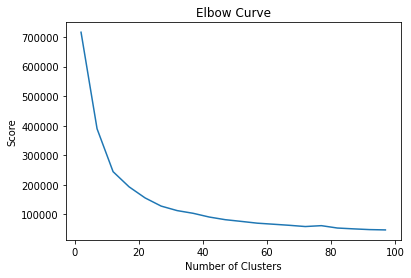

In [27]:
#plotando o gráfico
import pandas as pd
df_cost = pd.DataFrame(cost[0:])
df_cost.columns = ["cost"]
new_col = list(range(2,nmax,5))
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()
#k = 20

In [28]:
#criando o kMeans
kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(20).setSeed(SEED)

In [29]:
#ajustando o kmeans
model_kmeans = kmeans.fit(dados_pca)

In [30]:
#usando o modelo kmeans para gerar os dados
prections_kmeans = model_kmeans.transform(dados_pca)

In [31]:
#fazendo uma análise superficial dos resultados obtidos
prections_kmeans.select('pca_features', 'cluster_pca').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+-----------+
|pca_features                                                                                                               |cluster_pca|
+---------------------------------------------------------------------------------------------------------------------------+-----------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]    |4          |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]       |6          |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]    |3          |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828] |12         |
|[-0.4181406070145923,-2.131040791

#Filtrando imóveis do mesmo cluster

Para testar a eficiencia da metodológia foi selecionado um id de um imóvel qualquer e, inicialmente, foi feito uma filtragem nos dados do data frame por meior do cluster do imóvel selecionado.

Nota-se que utilizando somente o valor de cluster para realizar a filtragem existe uma determinada aleatoriedade nos resultados obtidos.

Para obter resultados mais consistentes foi feito o calculo da distância euclediana por meio das componentes de cluster_pca e os resultados foram ordenados do menor para o maior.

In [32]:
#selecionando um imóvel pelo id
id = prections_kmeans.select('id').collect()[0][0]
id

'00002dd9-cc74-4809-b5a5-850adf0e7526'

In [33]:
#analisando os dados do imóvel selecionado
prections_kmeans.filter(prections_kmeans.id == id).show(truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+-------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+-----------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|bairro      |

In [34]:
#armazenando o cluster_pca do imóvel em uma variável
cluster = prections_kmeans.filter(prections_kmeans.id == id).select('cluster_pca').collect()[0][0]
cluster

4

In [35]:
#filtrando os imóveis pelo cluster_pca do imóvel selecionado
imoveis_recomendados = prections_kmeans.filter(prections_kmeans.cluster_pca == cluster)
imoveis_recomendados.show()


+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+--------------------+--------------------+--------------------+-----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|            features|     scaled_features|        pca_features|cluster_pca|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+----

In [36]:
#apresentando as componentes que serão utilizadas para calcular a distância euclediana
componentes = imoveis_recomendados.filter(imoveis_recomendados.id == id).select('pca_features').collect()[0][0]
componentes

DenseVector([-6.1651, 1.3381, -1.7052, -0.5338, 0.089, -0.3134])

In [37]:
#importando bibliotecas utilizadas para calcular a distância euclediana
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f

In [38]:
#calculando distância euclediana entre o imóvel escolhido e os demais imóveis que pertencem ao mesmo cluster
def calcula_distance(value):
  return euclidean(componentes, value)

udf_calcula_distance = f.udf(calcula_distance, FloatType())
imoveis_recomendados_dist = imoveis_recomendados.withColumn('Dist', udf_calcula_distance('pca_features'))
recomendados = imoveis_recomendados_dist.select('id', 'bairro', 'Dist').sort('Dist')
recomendados.show(truncate=False)

+------------------------------------+------------+-----------+
|id                                  |bairro      |Dist       |
+------------------------------------+------------+-----------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|Santo Cristo|0.0        |
|5dac977a-6cfb-4283-a247-9478beca6bce|Centro      |0.008500492|
|a1c430e5-fe77-4b0f-a08c-001f57f11f89|Centro      |0.011903712|
|33aeb3e6-f85d-49b0-a758-c5252c5623e6|Centro      |0.019963495|
|a99baaa1-00ef-4906-8903-3f8a38a06385|Centro      |0.028192494|
|9bff3d1a-b865-4652-9b87-e26b3faf5c79|Centro      |0.037412748|
|d4b24d12-383c-4379-9ecb-89906f7dbba9|Centro      |0.037550464|
|d187d98b-2291-4865-8225-58497cc101c9|Santo Cristo|0.040353443|
|b3d1d649-f026-48ac-a0a5-dbb14ada1f61|Centro      |0.04079916 |
|1238503b-dbbc-4664-a48b-e94195624404|Santo Cristo|0.04395238 |
|562af84b-6b6d-4220-b79b-426a79148cb9|Santo Cristo|0.04501169 |
|3fe19ed1-3b37-4ac9-8b2e-a8b8f27e25d6|Santo Cristo|0.04573038 |
|63b14166-0cd2-40fa-878d-51d3fae968e0|Sa

In [39]:
#criando a função recomendadora
def recomendador(id):
  cluster = prections_kmeans.filter(prections_kmeans.id == id).select('cluster_pca').collect()[0][0]
  imoveis_recomendados = prections_kmeans.filter(prections_kmeans.cluster_pca == cluster)
  componentes = imoveis_recomendados.filter(imoveis_recomendados.id == id).select('pca_features').collect()[0][0]
  udf_calcula_distance = f.udf(calcula_distance, FloatType())
  imoveis_recomendados_dist = imoveis_recomendados.withColumn('Dist', udf_calcula_distance('pca_features'))
  recomendados = imoveis_recomendados_dist.select('id', 'bairro', 'area_util', 'valor', 'Zona Central', 'Zona Norte', 'Zona Oeste', 'Zona Sul', 'Dist').sort('Dist')
  recomendados.show(truncate=False)

In [40]:
#utilizando o mesmo id na função recomendadora
recomendador('00002dd9-cc74-4809-b5a5-850adf0e7526')

+------------------------------------+------------+---------+--------+------------+----------+----------+--------+-----------+
|id                                  |bairro      |area_util|valor   |Zona Central|Zona Norte|Zona Oeste|Zona Sul|Dist       |
+------------------------------------+------------+---------+--------+------------+----------+----------+--------+-----------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|Santo Cristo|35       |245000.0|1           |0         |0         |0       |0.0        |
|5dac977a-6cfb-4283-a247-9478beca6bce|Centro      |32       |276500.0|1           |0         |0         |0       |0.008500492|
|a1c430e5-fe77-4b0f-a08c-001f57f11f89|Centro      |31       |315926.0|1           |0         |0         |0       |0.011903712|
|33aeb3e6-f85d-49b0-a758-c5252c5623e6|Centro      |33       |331787.0|1           |0         |0         |0       |0.019963495|
|a99baaa1-00ef-4906-8903-3f8a38a06385|Centro      |29       |269900.0|1           |0         |0         |0     